# Gaussian Process

Après avoir étudié la méthode de l’Optimal Fingerprint, nous cherchons à explorer des approches plus récentes afin d’améliorer la détection du changement climatique. Grâce aux avancées en apprentissage automatique et en statistiques bayésiennes, il est possible de développer des méthodes plus performantes et robustes pour identifier les signaux du changement climatique dans les données climatiques.  

L’objectif de ce notebook est donc de mettre en œuvre une méthode de détection du changement climatique en combinant les statistiques bayésiennes et les machines à vecteurs de support (SVMs). Cette approche vise à optimiser la séparation des données et à affiner l’analyse des tendances climatiques afin d’obtenir des résultats plus précis et plus fiables.

# Sommaire

Introduction

0. Librairies
1. Implémentation, initialisation et test de la méthode
  0. Extraction et traitement des données de simulaation
  1. Implémentation de la méthode
    1. Séparation des données
        1. De manière aléatoire
        2. Avec des processus gaussiens
          - Avec sklearn
          - Avec gpytorch
    2. Validation des hyperparamètres avec validation croisée et entrainement du modèle
    3. Test statistique fréquentiste pour la détection du changement climatique
    4. Evaluation du modèle
    5. Test bayésien pour la détection du changement climatique
    6. Application de la méthode sur les sonnées de test
    7. Mesure de la différence entre les deux différentes méthodes de séparation des données
2. Test de la méthode sur des observations
  1. Détection du changelent climatique à l'échelle mondiale
  2. Détection du changeent climatique en Europe
  Détection du changement climatique en Amérique du Nord
3. Application sur de nouvelles données (précipitations extrêmes)

Conclusion

# Introduction

Le changement climatique est un phénomène global dont la détection repose sur l'analyse rigoureuse des données climatiques. La méthode de l’Optimal Fingerprint (OF) est une approche statistique classique largement utilisée pour identifier et quantifier l’influence des activités humaines sur le climat. Cependant, avec l’évolution des techniques d’apprentissage automatique et des outils statistiques avancés, il est possible d’exploiter des méthodes plus récentes pour améliorer la détection du changement climatique.  

Dans ce travail, nous mettons en œuvre une approche combinant les statistiques bayésiennes et les machines à vecteurs de support (SVMs) pour identifier les signes du changement climatique à partir de simulations et d'observations. Cette méthode vise à optimiser la séparation des données en utilisant des techniques avancées, notamment des processus gaussiens pour une meilleure structuration des ensembles d’apprentissage et de test.  

Notre approche repose sur plusieurs étapes clés :  
- Traitement et extraction des données issues de simulations climatiques.  
- Implémentation d’un modèle intégrant des méthodes de séparation aléatoire ou guidée par des processus gaussiens.  
- Validation et entraînement du modèle à l’aide de la validation croisée et d’une sélection optimale des hyperparamètres.  
- Tests de détection du changement climatique, en utilisant à la fois des approches fréquentistes et bayésiennes.  
- Application sur des observations réelles, à différentes échelles géographiques (monde, Europe, Amérique du Nord).  
- Généralisation du modèle sur de nouvelles données, notamment les précipitations extrêmes.  

L’objectif est d’évaluer dans quelle mesure ces nouvelles méthodes permettent une détection plus robuste et précise du changement climatique par rapport aux approches traditionnelles (comme l'OF).

## Comment on l'utilise ?

On va maintenant voir comment on va pouvoir implémenter.


1.   Séparer les données en 3 groupes (entrainement, validation et test) à l'aide des statistiques bayésiennes
2.   Déterminer les hyperparamètres du modèle vaec la cross validation
3.   Entraîner le modèle
3.   Déterminer le seuil de manière à controler l'erreur de type I (avec les données de validation)
4.   Déterminer la précision du notre nouveau modèle
5.   Evaluer et tester de variation de cettre méthode

# 0. Librairies

Les librairies que l'on va utiliser.

In [1]:
!pip install netCDF4
!pip install cftime
!pip install gpytorch
!pip install cartopy


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\DELSA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\DELSA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\DELSA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\DELSA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import xarray as xr
import numpy as np
import os
import cftime
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats as stats
#from google.colab import drive
#drive.mount('/content/drive')

Les fonctions de Scikit-learn dont on va avoir besoin

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

Les fonctions de GPyTorch dont on va avoir besoin

In [4]:
import torch
import gpytorch

# 1. Implémentation, initialisation et test de la méthode

## 0. Extraction et traitement des données de simulaation

Path pour l'extraction des données des simulations.

In [5]:
#path = 'drive/MyDrive/projet/data'
path = 'C:/Users/DELSA/Documents/travail/ProjetIndustriel/data'

On effectue le même traitement des données que dans la méthode de l'Optimal Fingerprint vu précédemment.

In [6]:
def reduce_granularity(ds, target_points):
    lat_points = ds.sizes['lat']
    lon_points = ds.sizes['lon']
    total_points = lat_points * lon_points
    factor = int(np.sqrt(total_points / target_points))
    factor = max(1, factor)
    ds_reduced = ds.coarsen(lat=factor, lon=factor, boundary='trim').mean()
    return ds_reduced

def traitement_data(ds, start_past, end_past, start_present, end_present, n_pt):
    data_past = ds.sel(time=slice(start_past, end_past))
    data_past = reduce_granularity(data_past, n_pt)
    seasonalities = data_past.groupby('time.month').mean('time')
    anomalies_past = data_past.groupby('time.month') - seasonalities
    anomalies_past_yearly = anomalies_past.resample(time='1YE').mean()

    data_present = ds.sel(time=slice(start_present, end_present))
    data_present = reduce_granularity(data_present, n_pt)
    anomalies_present = data_present.groupby('time.month') - seasonalities
    anomalies_present_yearly = anomalies_present.resample(time='1YE').mean()

    return anomalies_past_yearly.tas.data, anomalies_present_yearly.tas.data

Ici on va extraire les données pour les mettre deans un grand tableau en y ajoutant un label, 0 pour les données du passé (avant 1950) qui représentent des données sans changement climatique et 1 pour les données du présent (après 1950) pour lésquelles il y a un changement climatique.

In [7]:
def create_tab(path, start_past, end_past, start_present, end_present, n_f, nb_pts):
    if n_f == 0 or n_f > 50:
        n = 50
    else:
        n = n_f

    all_data = []
    all_labels = []

    for file_name in os.listdir(path)[:n]:
        full_path = os.path.join(path, file_name)
        xarray = xr.open_dataset(full_path)

        past, present = traitement_data(xarray, start_past, end_past, start_present, end_present, nb_pts)

        time_p, lat_p, lon_p = past.shape
        past_reshaped = past.reshape((time_p, lat_p * lon_p))
        labels_past = np.zeros((time_p, 1))  # Label 0 pour le passé

        time_c, lat_c, lon_c = present.shape
        present_reshaped = present.reshape((time_c, lat_c * lon_c))
        labels_present = np.ones((time_c, 1))  # Label 1 pour le présent

        all_data.append(np.vstack((past_reshaped, present_reshaped)))
        all_labels.append(np.vstack((labels_past, labels_present)))

    all_data = np.vstack(all_data)
    all_labels = np.vstack(all_labels)

    return all_data, all_labels

In [8]:
start_past = '1880-01-16'
end_past = '1950-01-16'

start_present = '1950-01-16'
end_present = '2022-12-16'

nb_composents = 30 # choix arbitraire
nb_pts = 1000
nb_fichiers = 50 # pour tous les fichiers

In [9]:
data, labels = create_tab(path, start_past, end_past, start_present, end_present, nb_fichiers, nb_pts)
labels = labels.ravel()  # Convertir en vecteur 1D

## 1. Implémentation de la méthode

### 1. Séparation des données

On va chercher à séparer nos données en 3 groupes distincts:

- Les données d'entrainement qui vont permettre d'entraîner le modèle. Cela va représenter 60% de nos données.
- Les données de validation qui vont nous servir à faire la cross validation et déterminer les hyperparamètre du modèle. Cela va représenter 20% de nos données.
- Les données de tests qui vont nous permettre de quantifier la précision de notre modèle. Elles vont représenter 20% de nos données.

Pour réaliser cette séparation des données, nous allons utiliser plusieurs méthodes. La première consiste à assigner aléatoirement un groupe à chacune des données. Pour les deux suivantes on va utiliser les statistiques bayésiennes et porcessus gausiens. Pour l'une des duex on va utiliser la librairie `sklearn` alors que pour l'autre, on va utiliser la librairie `gpytorch`.


#### Séparation aléatoire

Dans cette première partie, on va utiliser la méthode la plus simple qui consite tout simplment à choisir aléatoirement des points pour créer des sous groupe de taille souhaité.

In [10]:
def split_data(data, labels, test_size=0.2, val_size=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=test_size + val_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

#### Méthode utilisant les statistiques bayésienne et les processus gausiens

Explication de la méthode de split utilisant les statistiques bayésiennes ainsi que les processus gaussiens.

##### Approche avec sklearn

On commancer par utiliser les fonctions de sklearn qui nous permettent de rapidement appliqué notre méthode.

In [11]:
def split_data_bayes_sk(data, labels, test_size=0.2, val_size=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.90, random_state=42)

    # Train Gaussian Process Model using scikit-learn
    kernel = C(1.0) * RBF(length_scale=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)

    # Predict uncertainties
    _, uncertainty = gp.predict(data, return_std=True) # retourne la moyenne et l'ecart type
    uncertainty = np.square(uncertainty)  # Convert standard deviation to variance
    uncertainty += np.random.randn(*uncertainty.shape) * 1e-6 # ajout du bruit
    uncertainty = (uncertainty - np.min(uncertainty)) / (np.max(uncertainty) - np.min(uncertainty)) # on normalise


    # Define uncertainty thresholds
    q1 = np.quantile(uncertainty, 1 - test_size - val_size)
    q2 = np.quantile(uncertainty, 1 - test_size)

    # Split data based on uncertainty
    idx_train = np.where(uncertainty <= q1)[0]  # Low uncertainty → Train
    idx_val = np.where((uncertainty > q1) & (uncertainty <= q2))[0]  # Medium uncertainty → Validation
    idx_test = np.where(uncertainty > q2)[0]  # High uncertainty → Test
    print(f"les valeurs de q1 et q2 sont : q1 {q1} et q2 {q2}")

    X_train, y_train = data[idx_train], labels[idx_train]
    X_val, y_val = data[idx_val], labels[idx_val]
    X_test, y_test = data[idx_test], labels[idx_test]

    return X_train, X_val, X_test, y_train, y_val, y_test


##### Approche en utilisant gpytorch

La méthode précédente agit comme une boite noire, on ne sait pas vraiment
comment la méthode fonctionne, c'est pourquuoi nous avons décidé d'utiliser la librairie gpytorch. Elle nous permet de mieux comprendre le comprendre le fonctionnement de notre code mais aussi d'avoir plus de contrôle sur ce qui est fait.

Explication de comment la métthode est utilisé.

Pour réaliser cette méthode, nous nous sommes aider de cette [exemple](https://docs.gpytorch.ai/en/v1.12/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html) utilisant les processus gaussiens (SVGP).

Commençons par définir notre modèle de Gaussian Process.

Ici on va utiliser un Gaussian Process Variationnel (SVGP) et non un Gaussian Process Exact (EGP) car il est moins coûteux et parce qu'on a beaucoup de points. En effet l'EGP a un coût en *$O(N^3)$* en calcul et un coût en *$O(N^2)$* en mémoire.

In [12]:
class SVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # mettre un kernel polynomial => gpytorch.kernels.PolynomialKernel(power) surement mieux et adéquation avec la SVM

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Faire les explication des étapes de la fonction et comment on les a fait.

On prend une partie des données que l'on utiliser pour entrainer notre SVGP.

On convertie ensuite nos tableau numpy en tensor pour pouvoir bien utiliser notre GP

Initilisation du modèle:

Entrainement du modèle:

Prédiction de la variance sur les données:

Séparation des données:

In [13]:
def split_data_bayes_torch(data, labels, test_size=0.2, val_size=0.2):
    X_train, _, _, y_train, _, _ = split_data(data, labels, 0.475, 0.475)

    # Convertir les tableau numpy en tensor
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    # Initialisation du modèle avec une petite partie des données
    model = SVGPModel(X_train)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # Entrainement du modèle
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=data_tensor.size(0))

    max_iters = 2000
    previous_loss = float('inf')
    tolerance = 1e-3  # Critère d’arrêt

    for i in range(max_iters): # utiliser de minibatch
        optimizer.zero_grad()
        output = model(data_tensor)
        loss = -mll(output, labels_tensor)
        loss.backward()
        optimizer.step()

        if abs(previous_loss - loss.item()) < tolerance:
            # print(f"Arrêt après {i+1} itérations, perte stabilisée à {loss.item():.4f}")
            break

        previous_loss = loss.item()

    # Prédiction de la variance sur les données
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        pred = likelihood(model(data_tensor))
        uncertainty = pred.variance  # Incertitude bayésienne

    # Séparation des données
    # On a un problème, avec la prédiction on a beaucoup de fois la meme valeur donc les quantiles sont égaux donc on rajoute un léger bruit pour éviter ce problème

    noise = torch.randn_like(uncertainty) * 1e-6
    uncertainty = uncertainty + noise  # Ajouter le bruit

    # print(uncertainty)

    # Seuils pour le test et validation
    q1 = torch.quantile(uncertainty, 1 - test_size - val_size)
    q2 = torch.quantile(uncertainty, 1 - test_size)

    # print(q1, q2)

    # On va avoir les données avec le moins d'incertitudes pour le test et les données avec le plus d'incertitude pour la validation (est ce que l'on doit bien les mettre dans ce sens là?)

    idx_train = torch.where(uncertainty <= q1)[0]  # Faible incertitude -> Train
    idx_val = torch.where((uncertainty > q1) & (uncertainty <= q2))[0]  # Incertitude moyenne -> Validation
    idx_test = torch.where(uncertainty > q2)[0]  # Forte incertitude -> Test

    X_train, y_train = data[idx_train], labels[idx_train]
    X_val, y_val = data[idx_val], labels[idx_val]
    X_test, y_test = data[idx_test], labels[idx_test]

    return X_train, X_val, X_test, y_train, y_val, y_test

Pour la suite, nous allons utiliser cette dernière méthode pour séparer nos données car on va le voir par la suite mais elle est meilleure que la séparation aléatoire et n'est pas une boite noire comme peut l'être celle avec les fonction de `sklearn`.

### 2. Validation des hyperparamètres avec validation croisée et entrainement du modèle

[lien](https://medium.com/@prayushshrestha89/tuning-svm-hyperparameters-making-your-classifier-shine-like-a-pro-8673639ddb16) pour les hyperparamètre pour les SVM.

Le choix de nos paramètres pour notre SVM:


*   kernel polynomial pour essayer d'avoir la meilleur découpe (attention à l'overfitting)
*   gamma = 1 (voir 0,1) pour avoir une vue d'ensemble et ne pas se concentrer sur chaque inperfection dans les données
*   C = 1 (voir 10), ça a l'air bien pour nous mais j'ai pas bien compris l'impact que ce paramètre a sur le modèle
*   degree = 3 ou 4, pas trop pour éviter l'overfitting mais assez pour avoir les bénéfices de du noyau

sur l'article on voit qu'avec le noyau rbf on un résultat très similaire avec celui d'un noyau polynomial de degré 2, c'est normal ou juste un coup de chance (je pense pour la première option mais je suis pas sur)

On cherche les meileurs paramètres gamma, C et degree pour avoir le meilleur modèle possible.

On va faire varier:
- le type de kernel
- gamma qui va prendre les valeurs 0.1, 1, 10
- C de la meme façon
- degré égal à 2, 3 ou 4

In [70]:
def model(X_train, y_train):
    param = {
        'kernel': ['poly'], # , 'rbf'
        'C': [0.1, 1, 10],
        'gamma': [0.1, 1, 10],
        'degree': [2, 3, 4]  # Seulement pour 'poly'
    }

    svm = SVC(probability=True, random_state=42)
    grid_search = GridSearchCV(svm, param, cv=5, n_jobs=-1, scoring='accuracy')
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=4000, random_state=42, stratify=y_train)
    grid_search.fit(X_train_subset, y_train_subset)

    best_params = grid_search.best_params_

    print("Meilleurs paramètres sélectionnés :", best_params)

    best_model = grid_search.best_estimator_
    return best_model

## Etape 3: Déterminer le seuil

Ici, on ne cherche pas juste à classifier, mais à réaliser un test d’hypothèse. L’idée est de fixer un seuil alpha pour contrôler l’erreur et maximiser la puissance du test.

Avec un SVC, chaque observation Xi reçoit une probabilité d’appartenir à la classe 1. Par défaut, on prédit 1 si la probabilité dépasse 0.5, sinon 0. Mais ce seuil peut être ajusté pour mieux contrôler l’erreur de type I.

Pour ça, on peut utiliser la fonction roc_curve de sklearn afin de trouver le seuil qui garantit une erreur de type I égale à alpha. Ensuite, on devra valider ce seuil sur de nouvelles données.

In [71]:
def find_optimal_threshold(X_val, y_val, svm_model, alpha):
    y_pred_proba = svm_model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba) # erreur de type I, erreur de type II (=puissance) et seuil
    idx = np.argmin(np.abs(fpr - alpha))
    return fpr[idx], tpr[idx], thresholds[idx]

## Etape 4: Déterminer la précision de notre modèle

Pour pouvoir déterminer la précision de notre modèle, on va tout d'abord déterminer la probabilité de détecter un changement climatique. On va ensuite comparer cette probabilité avec le seuil que l'on a déterminer précédemment. Si la probabilité est supérieure au seuil alors on détecte un changement climatique. Cela permet d'allier la puissance des SVM et celle des tests statistiques. ensuite on peut comparer les valeurs prédites avec les valeurs exactes pour avoir la précision.

In [72]:
def model_accuracy(X_test, y_test, svm_model, thresholds):
    score = svm_model.decision_function(X_test)
    y_pred = (score > thresholds).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

## Etape 5: Score du modèle

In [73]:
def evaluate_model(X_val, y_val, X_test, y_test, alpha, svm_model):
    fpr, tpr, threshold = find_optimal_threshold(X_val, y_val, svm_model, alpha)
    accuracy = model_accuracy(X_test, y_test, svm_model, threshold)
    return fpr, tpr, accuracy

In [74]:
def score_model(data, labels, alpha): # Changer le nom en train_score_model
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_bayes_torch(data, labels)
    svm_model = model(X_train, y_train)
    fpr, tpr, accuracy = evaluate_model(X_val, y_val, X_test, y_test, alpha, svm_model)
    return svm_model, fpr, tpr, accuracy

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, labels)
svm_model_classic = model(X_train, y_train)
fpr, tpr, threshold = find_optimal_threshold(X_val, y_val, svm_model_classic, 0.05)
accuracy = model_accuracy(X_test, y_test, svm_model_classic, threshold)

print("Avec la séparation classique")
print(f"Puissance du test: {tpr}")
print(f"Précision du modèle: {accuracy}")
print(f"Erreur de type I: {fpr}")

In [ ]:
svm_model, errI, pwr, accuracy = score_model(data, labels, 0.05)
print("Avec la séparation bayésienne")
print(f"Puissance du test: {pwr}")
print(f"Précision du modèle: {accuracy}")
print(f"Erreur de type I: {errI}")

Meilleurs paramètres sélectionnés : {'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
Avec la séparation bayésienne
Puissance du test: 0.7968526466380543
Précision du modèle: 0.8248337028824834
Erreur de type I: 0.05014749262536873


### Test sur $\alpha$

In [ ]:
list_alpha = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.3]

res_pwr = np.array([])
res_accuracy = np.array([])
res_errI = np.array([])
res_pwr_classic = np.array([])
res_accuracy_classic = np.array([])
res_errI_classic = np.array([])

X_train, X_val, X_test, y_train, y_val, y_test = split_data_bayes_torch(data, labels)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = split_data(data, labels)

for alpha in list_alpha:

    fpr, tpr, accuracy = evaluate_model(X_val, y_val, X_test, y_test, alpha, svm_model)
    c_fpr, c_tpr, c_accuracy = evaluate_model(X_val2, y_val2, X_test2, y_test2, alpha, svm_model_classic)

    res_pwr = np.append(res_pwr, tpr)
    res_accuracy = np.append(res_accuracy, accuracy)
    res_errI = np.append(res_errI, fpr)

    res_pwr_classic = np.append(res_pwr_classic, c_tpr)
    res_accuracy_classic = np.append(res_accuracy_classic, c_accuracy)
    res_errI_classic = np.append(res_errI_classic, c_fpr)


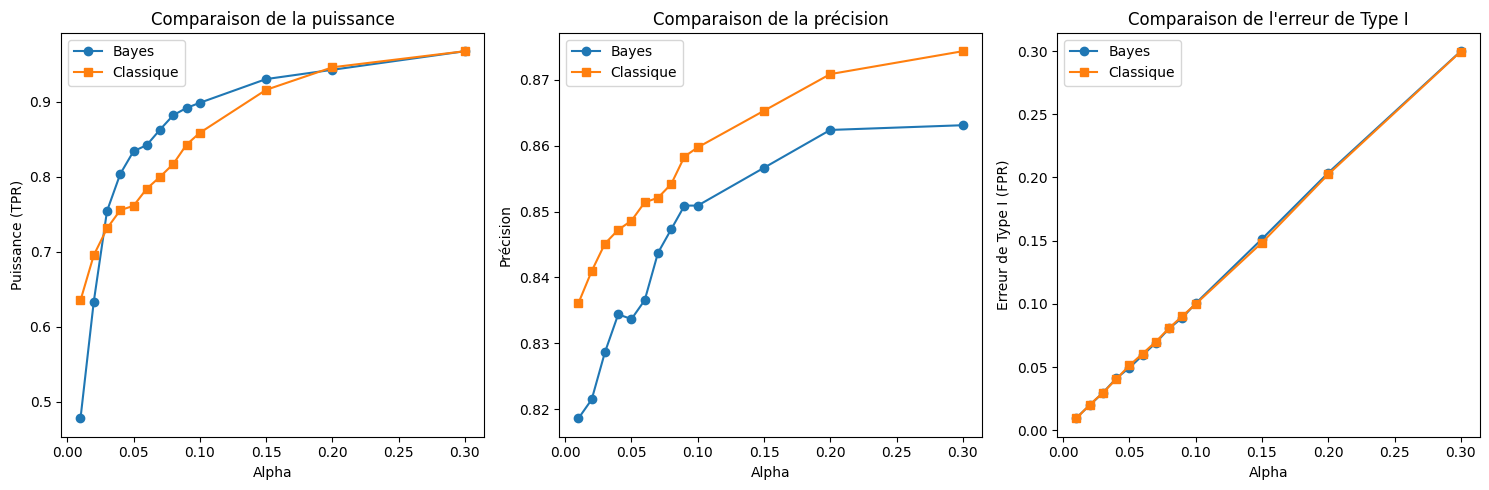

In [ ]:
plt.figure(figsize=(15, 5))

# Plot de la puissance (TPR)
plt.subplot(1, 3, 1)
plt.plot(list_alpha, res_pwr, marker='o', label='Bayes')
plt.plot(list_alpha, res_pwr_classic, marker='s', label='Classique')
plt.xlabel("Alpha")
plt.ylabel("Puissance (TPR)")
plt.title("Comparaison de la puissance")
plt.legend()

# Plot de la précision (Accuracy)
plt.subplot(1, 3, 2)
plt.plot(list_alpha, res_accuracy, marker='o', label='Bayes')
plt.plot(list_alpha, res_accuracy_classic, marker='s', label='Classique')
plt.xlabel("Alpha")
plt.ylabel("Précision")
plt.title("Comparaison de la précision")
plt.legend()

# Plot de l'erreur de type I (FPR)
plt.subplot(1, 3, 3)
plt.plot(list_alpha, res_errI, marker='o', label='Bayes')
plt.plot(list_alpha, res_errI_classic, marker='s', label='Classique')
plt.xlabel("Alpha")
plt.ylabel("Erreur de Type I (FPR)")
plt.title("Comparaison de l'erreur de Type I")
plt.legend()

plt.tight_layout()
plt.show()

On observe que le modèle avec la séparation bayesienne est a une puissance du test et une précision nettement meilleure que le modèle avec la séparation classique.


# Test sur les observations

## Extraction des données d'observation

Path pour l'extraction des données d'observation.

In [ ]:
#path_obs = 'drive/MyDrive/projet/data_observation_ERA5'
path_obs = 'C:/Users/DELSA/Documents/travail/ProjetIndustriel/data_obs'
file_name = "ERA5_1940-2024_Monthly_TAS.nc"

On commence par extraire et trater nos données d'observation.

In [ ]:
obs = xr.open_dataset(path_obs + '/' + file_name)
print(f"Processing file: {file_name}")

Processing file: ERA5_1940-2024_Monthly_TAS.nc


On convertie la date dans le format souhaité.

In [ ]:
obs['date'] = pd.to_datetime(obs['date'], format='%Y%m%d') # convertion de la date

On réduit la dimension des données.

In [ ]:
def reduce_granularity_obs(ds, target_points):
    lat_points = ds.sizes['latitude']
    lon_points = ds.sizes['longitude']
    total_points = lat_points * lon_points
    factor = int(np.sqrt(total_points / target_points))
    ds_reduced = ds.coarsen(latitude=factor, longitude=factor, boundary='trim').mean()
    return ds_reduced

In [ ]:
obs = reduce_granularity_obs(obs, np.shape(data)[1])

On calcul la saisonalité.

In [ ]:
print(obs['date'].isel(date=120))

<xarray.DataArray 'date' ()> Size: 8B
array('1950-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    number   int64 8B 0
    date     datetime64[ns] 8B 1950-01-01
    expver   <U4 16B '0001'


In [ ]:
data_past = obs.isel(date=slice(0, 120)) # on choisit les 50 premières dates pour représenter le passé

seasonalities = data_past.groupby('date.month').mean("date")

anomalies_obs = obs.groupby('date.month') - seasonalities
anomalies_obs = anomalies_obs.resample(date='1YE').mean()

On réduit la dimension.

In [ ]:
date, longitude, latitude = anomalies_obs.sizes['date'], anomalies_obs.sizes['longitude'], anomalies_obs.sizes['latitude']
anomalies_obs = np.array(anomalies_obs.to_dataarray())
anomalies_obs = anomalies_obs.reshape(date, longitude * latitude)

En faire une fonction (pas sur qu'elle soit vraiment utile)

In [ ]:
def traitement_data_obs(path_obs, file_mane, start_past, end_past, start_present, end_present, n_pt):
    obs = xr.open_dataset(path_obs + '/' + file_name)
    print(f"Processing file: {file_name}")

    obs['date'] = pd.to_datetime(obs['date'], format='%Y%m%d') # convertion de la date

    obs = reduce_granularity_obs(obs, n_pt)

    data_past = obs.isel(date=slice(0, 120)) # on choisit les 50 premières dates pour représenter le passé

    seasonalities = data_past.groupby('date.month').mean("date")

    anomalies_obs = obs.groupby('date.month') - seasonalities
    anomalies_obs = anomalies_obs.resample(date='1YE').mean()

    date, longitude, latitude = anomalies_obs.sizes['date'], anomalies_obs.sizes['longitude'], anomalies_obs.sizes['latitude']
    anomalies_obs = np.array(anomalies_obs.to_dataarray())
    anomalies_obs = anomalies_obs.reshape(date, longitude * latitude)

    return anomalies_obs

In [ ]:
anomalies_obs = traitement_data_obs(path_obs, file_name, start_past, end_past, start_present, end_present, np.shape(data)[1])

Processing file: ERA5_1940-2024_Monthly_TAS.nc


## Application du modèle

On donne nos données d'observation au modèle que l'on a entrainé pour qu'il nous retour si il y a un changement climatique ou non pour chacune des années.

In [ ]:
X_obs = anomalies_obs
y_obs = svm_model.predict(X_obs)

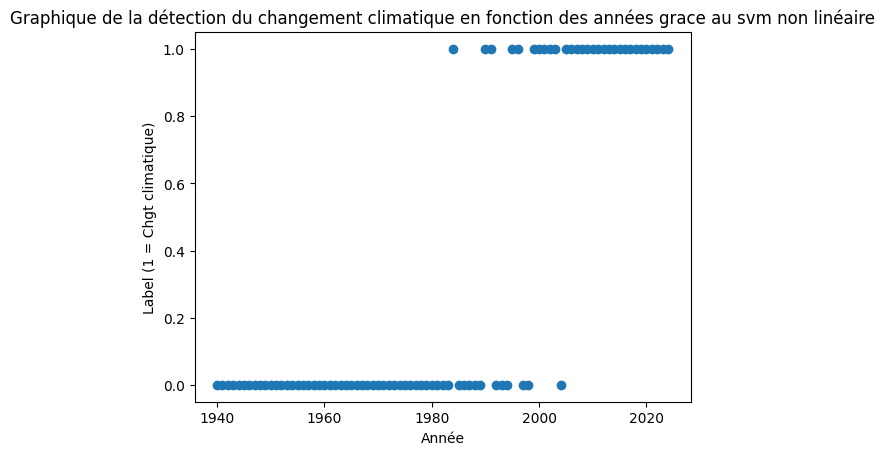

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, y_obs, 'o')
plt.xlabel('Année')
plt.ylabel('Label (1 = Chgt climatique)')
plt.title('Graphique de la détection du changement climatique en fonction des années grace au svm non linéaire')
plt.show()

## Sur une partie du monde

Avec cette fonction, on va pouvoir séléctionner uniquement les données dans une région spécifique (dans le carré délimiter par deux valeurs de latitudes et longitudes).

Pas exemple, pour l'Amérique du nord, l'encadrement ce fait avec 83°N et 7°N pour la latitude et 172°W et 52°W pour la longitude et pour l'Europe 71°N, 36°N, 25°W et 50°E

In [ ]:
def create_tab_region(path, start_past, end_past, start_present, end_present, n_f, nb_pts, lat_min, lat_max, long_min, long_max):
    if n_f == 0 or n_f > 50:
        n = 50
    else:
        n = n_f

    all_data = []
    all_labels = []

    for file_name in os.listdir(path)[:n]:
        full_path = os.path.join(path, file_name)
        xarray = xr.open_dataset(full_path)

        # xarray = xarray.sel(lat=slice(lat_min, lat_max), lon=slice(long_min, long_max)) # ne fonctionne pas pour la latitude

        xarray = xarray.where((xarray.lat >= lat_min) & (xarray.lat <= lat_max) &
                          (xarray.lon >= long_min) & (xarray.lon <= long_max),
                          drop=True)

        past, present = traitement_data(xarray, start_past, end_past, start_present, end_present, nb_pts)

        time_p, lat_p, lon_p = past.shape
        past_reshaped = past.reshape((time_p, lat_p * lon_p))
        labels_past = np.zeros((time_p, 1))  # Label 0 pour le passé

        time_c, lat_c, lon_c = present.shape
        present_reshaped = present.reshape((time_c, lat_c * lon_c))
        labels_present = np.ones((time_c, 1))  # Label 1 pour le présent

        all_data.append(np.vstack((past_reshaped, present_reshaped)))
        all_labels.append(np.vstack((labels_past, labels_present)))

    all_data = np.vstack(all_data)
    all_labels = np.vstack(all_labels)

    return all_data, all_labels

In [ ]:
def reduce_granularity_obs2(ds, target_points):
    lat_points = ds.sizes['latitude']
    lon_points = ds.sizes['longitude']

    # Ratio original de la grille
    aspect_ratio = lat_points / lon_points

    # Trouver la meilleure approximation de (lat_out, lon_out)
    lat_out = int(round(np.sqrt(target_points * aspect_ratio)))
    lon_out = int(round(target_points / lat_out))

    # Vérification finale
    if lat_out * lon_out != target_points:
        print(f"Impossible d'avoir exactement {target_points} points, ajustement à {lat_out * lon_out}.")

    # Assurer que les valeurs interpolées restent bien dans l'encadrement d'origine
    print(f"Latitude min: {ds.latitude.values.min()}, Latitude max: {ds.latitude.values.max()}")
    print(f"Longitude min: {ds.longitude.values.min()}, Longitude max: {ds.longitude.values.max()}")

    new_lat = np.linspace(ds.latitude.values.min(), ds.latitude.values.max(), lat_out, endpoint=True)
    new_lon = np.linspace(ds.longitude.values.min(), ds.longitude.values.max(), lon_out, endpoint=True)

    # Interpolation
    ds_reduced = ds.interp(latitude=new_lat, longitude=new_lon, method="linear")

    return ds_reduced

In [ ]:
def plot_anomalies(anomalies_obs_AM, latitudes, longitudes, date_index=-1, zoom_extent=None):
    """
    Trace une carte des anomalies pour une date donnée avec possibilité de zoom sur une région personnalisée.

    Parameters:
        anomalies_obs_AM (numpy.ndarray): Tableau 3D des anomalies (date, latitude, longitude)
        latitudes (numpy.ndarray): Tableau des latitudes
        longitudes (numpy.ndarray): Tableau des longitudes
        date_index (int): Index de la date à afficher (par défaut la dernière)
        zoom_extent (list or tuple, optional): [lon_min, lon_max, lat_min, lat_max] pour définir la zone de zoom
    """
    # Vérification des dimensions pour éviter les erreurs de reshape
    if anomalies_obs_AM.shape[1] != len(latitudes) or anomalies_obs_AM.shape[2] != len(longitudes):
        raise ValueError("Les dimensions des anomalies ne correspondent pas aux latitudes et longitudes fournies.")

    # Extraire la carte des anomalies pour la date spécifiée
    anomalies_map = anomalies_obs_AM[date_index]

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

    # Convertir les longitudes de [0, 360] à [-180, 180] si nécessaire
    # longitudes = np.where(longitudes > 180, longitudes - 360, longitudes)

    latitudes = np.where(latitudes > 90, latitudes - 180, latitudes)

    # Vérification avant de définir l'extension
    if np.isnan(longitudes.min()) or np.isnan(longitudes.max()) or np.isnan(latitudes.min()) or np.isnan(latitudes.max()):
        raise ValueError("Erreur : Les coordonnées contiennent des NaN.")

    if np.isinf(longitudes.min()) or np.isinf(longitudes.max()) or np.isinf(latitudes.min()) or np.isinf(latitudes.max()):
        raise ValueError("Erreur : Les coordonnées contiennent des valeurs infinies.")

    # Définir l'étendue de la carte
    if zoom_extent:
        ax.set_extent(zoom_extent, crs=ccrs.PlateCarree())
    else:
        ax.set_extent([longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()], crs=ccrs.PlateCarree())


    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Afficher les anomalies avec un colormap
    # im = ax.pcolormesh(longitudes, latitudes, anomalies_map, transform=ccrs.PlateCarree(), cmap='coolwarm')

    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)
    im = ax.pcolormesh(lon_grid, lat_grid, anomalies_map, transform=ccrs.PlateCarree(), cmap='coolwarm')


    # Ajouter une barre de couleur
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label('Anomalies')

    plt.title(f'Carte des Anomalies - Date index {date_index}')
    plt.show()

In [ ]:
obs = xr.open_dataset(path_obs + '/' + file_name)
print(f"Processing file: {file_name}")

obs['date'] = pd.to_datetime(obs['date'], format='%Y%m%d') # convertion de la date

Processing file: ERA5_1940-2024_Monthly_TAS.nc


### Pour l'Amérique du Nord

Création du modèle

In [ ]:
data_AM, labels_AM = create_tab_region(path, start_past, end_past, start_present, end_present, nb_fichiers, 750, 15, 73, 188, 308)
labels_AM = labels_AM.ravel()

In [ ]:
svm_model_AM, errI, power_AM, accuracy = score_model(data_AM, labels_AM, 0.05)
print(f"Puissance du test AM: {power_AM}")

Meilleurs paramètres sélectionnés : {'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
Puissance du test AM: 0.5237388724035609


Pour l'Amérique du Nord

In [ ]:
obs_AM = obs.where((obs.latitude >= 15) & (obs.latitude <= 73) &
                          (obs.longitude >= 188) & (obs.longitude <= 308),
                          drop=True)

print(f"Latitude min: {obs_AM.latitude.values.min()}, Latitude max: {obs_AM.latitude.values.max()}")
print(f"Longitude min: {obs_AM.longitude.values.min()}, Longitude max: {obs_AM.longitude.values.max()}")

obs_AM = reduce_granularity_obs2(obs_AM, np.shape(data_AM)[1])

data_past = obs_AM.isel(date=slice(0, 120)) # on choisit les 50 premières dates pour représenter le passé

seasonalities = data_past.groupby('date.month').mean("date")

anomalies_obs = obs_AM.groupby('date.month') - seasonalities
anomalies_obs = anomalies_obs.resample(date='1YE').mean()

anomalie_AM_map = anomalies_obs
longitudes_AM, latitudes_AM = anomalie_AM_map.coords['longitude'].values, anomalie_AM_map.coords['latitude'].values

date, longitude, latitude = anomalies_obs.sizes['date'], anomalies_obs.sizes['longitude'], anomalies_obs.sizes['latitude']
anomalies_obs = np.array(anomalies_obs.to_dataarray())
anomalies_obs_AM = anomalies_obs.reshape(date, longitude * latitude)

print(np.shape(anomalies_obs_AM), np.shape(data_AM)[1])

Latitude min: 15.0, Latitude max: 73.0
Longitude min: 188.0, Longitude max: 308.0
Latitude min: 15.0, Latitude max: 73.0
Longitude min: 188.0, Longitude max: 308.0
(85, 1104) 1104


In [ ]:
print(obs.coords['latitude'].values.min(), obs.coords['latitude'].values.max())
print(obs.coords['longitude'].values.min(), obs.coords['longitude'].values.max())

print(obs_AM.coords['latitude'].values.min(), obs_AM.coords['latitude'].values.max())
print(obs_AM.coords['longitude'].values.min(), obs_AM.coords['longitude'].values.max())

-90.0 90.0
0.0 359.75
15.0 73.0
188.0 308.0


In [ ]:
print(latitudes_AM)
print(longitudes_AM)

[15.         17.63636364 20.27272727 22.90909091 25.54545455 28.18181818
 30.81818182 33.45454545 36.09090909 38.72727273 41.36363636 44.
 46.63636364 49.27272727 51.90909091 54.54545455 57.18181818 59.81818182
 62.45454545 65.09090909 67.72727273 70.36363636 73.        ]
[188.         190.55319149 193.10638298 195.65957447 198.21276596
 200.76595745 203.31914894 205.87234043 208.42553191 210.9787234
 213.53191489 216.08510638 218.63829787 221.19148936 223.74468085
 226.29787234 228.85106383 231.40425532 233.95744681 236.5106383
 239.06382979 241.61702128 244.17021277 246.72340426 249.27659574
 251.82978723 254.38297872 256.93617021 259.4893617  262.04255319
 264.59574468 267.14893617 269.70212766 272.25531915 274.80851064
 277.36170213 279.91489362 282.46808511 285.0212766  287.57446809
 290.12765957 292.68085106 295.23404255 297.78723404 300.34042553
 302.89361702 305.44680851 308.        ]


In [ ]:
print(latitudes_AM.size)
print(longitudes_AM.size)
anomalies_obs_AM = anomalies_obs_AM.reshape(anomalies_obs_AM.shape[0], latitudes_AM.size, longitudes_AM.size)
print(anomalies_obs_AM.shape)

23
48
(85, 23, 48)


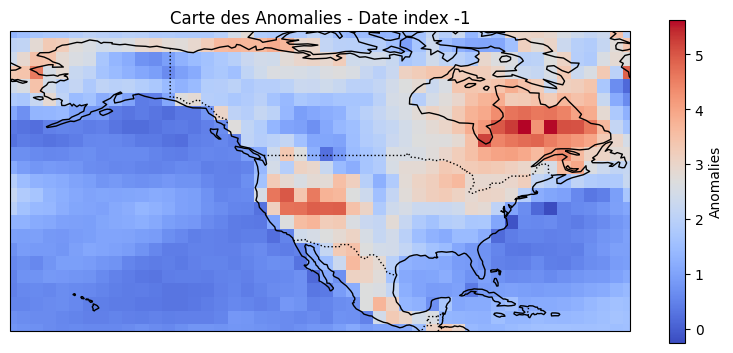

In [ ]:
plot_anomalies(anomalies_obs_AM, latitudes_AM, longitudes_AM)

Test

In [ ]:
anomalies_obs_AM = anomalies_obs_AM.reshape(anomalies_obs_AM.shape[0], latitudes_AM.size * longitudes_AM.size)
X_obs_AM = anomalies_obs_AM
y_obs_AM = svm_model_AM.predict(X_obs_AM)

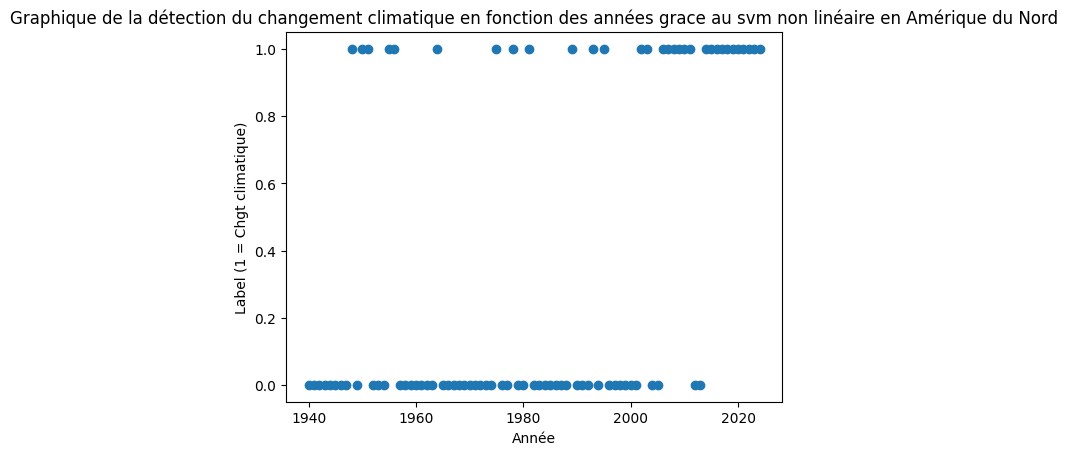

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, y_obs_AM, 'o')
plt.xlabel('Année')
plt.ylabel('Label (1 = Chgt climatique)')
plt.title('Graphique de la détection du changement climatique en fonction des années grace au svm non linéaire en Amérique du Nord')
plt.show()

### Pour l'Europe

Extraction des données de simulations

In [ ]:
data_EU, labels_EU = create_tab_region(path, start_past, end_past, start_present, end_present, nb_fichiers, 750, 36, 71, 0, 60)
labels_EU = labels_EU.ravel()

Création du modèle

In [ ]:
svm_model_EU, errI, power_EU, accuracy = score_model(data_EU, labels_EU, 0.05)
print(f"Puissance du test EU: {power_EU}")

Meilleurs paramètres sélectionnés : {'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
Puissance du test EU: 0.4993983152827918


Extraction et traitement des données d'observation

In [ ]:
obs_EU = obs.where((obs.longitude >= 0) & (obs.longitude <= 60) &
                   (obs.latitude >= 36) & (obs.latitude <= 71), drop=True)

print(f"Latitude min: {obs_EU.latitude.values.min()}, Latitude max: {obs_EU.latitude.values.max()}")
print(f"Longitude min: {obs_EU.longitude.values.min()}, Longitude max: {obs_EU.longitude.values.max()}")

obs_EU = reduce_granularity_obs2(obs_EU, np.shape(data_EU)[1])

data_past = obs_EU.isel(date=slice(0, 120)) # on choisit les 50 premières dates pour représenter le passé

seasonalities = data_past.groupby('date.month').mean("date")

anomalies_obs = obs_EU.groupby('date.month') - seasonalities
anomalies_obs = anomalies_obs.resample(date='1YE').mean()

anomalie_EU_map = obs_EU
longitudes_EU, latitudes_EU = anomalie_EU_map.coords['longitude'].values, anomalie_EU_map.coords['latitude'].values

date, longitude, latitude = anomalies_obs.sizes['date'], anomalies_obs.sizes['longitude'], anomalies_obs.sizes['latitude']
anomalies_obs = np.array(anomalies_obs.to_dataarray())
anomalies_obs_EU = anomalies_obs.reshape(date, longitude * latitude)

print(np.shape(anomalies_obs_EU), np.shape(data_EU)[1])

Latitude min: 36.0, Latitude max: 71.0
Longitude min: 0.0, Longitude max: 60.0
Latitude min: 36.0, Latitude max: 71.0
Longitude min: 0.0, Longitude max: 60.0
(85, 336) 336


In [ ]:
print(latitudes_EU)
print(longitudes_EU)

[36.         38.69230769 41.38461538 44.07692308 46.76923077 49.46153846
 52.15384615 54.84615385 57.53846154 60.23076923 62.92307692 65.61538462
 68.30769231 71.        ]
[ 0.          2.60869565  5.2173913   7.82608696 10.43478261 13.04347826
 15.65217391 18.26086957 20.86956522 23.47826087 26.08695652 28.69565217
 31.30434783 33.91304348 36.52173913 39.13043478 41.73913043 44.34782609
 46.95652174 49.56521739 52.17391304 54.7826087  57.39130435 60.        ]


In [ ]:
print(latitudes_EU.size)
print(longitudes_EU.size)
anomalies_obs_EU = anomalies_obs_EU.reshape(anomalies_obs_EU.shape[0], latitudes_EU.size, longitudes_EU.size)
print(anomalies_obs_EU.shape)

14
24
(85, 14, 24)


Affichage de la carte

C:\Users\DELSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\DELSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


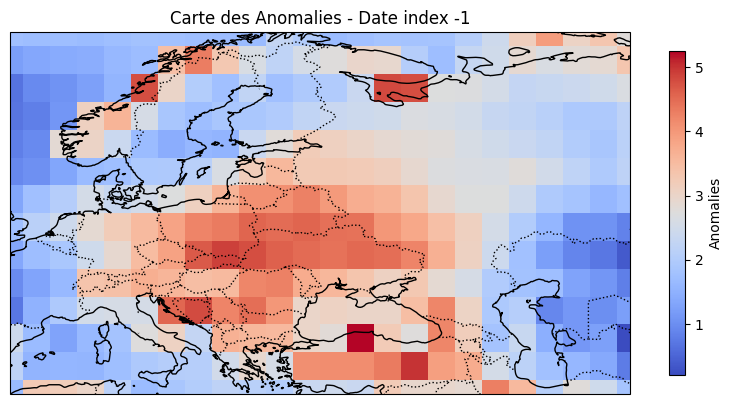

In [ ]:
plot_anomalies(anomalies_obs_EU, latitudes_EU, longitudes_EU)

Test sur les observations

In [ ]:
anomalies_obs_EU = anomalies_obs_EU.reshape(anomalies_obs_EU.shape[0], latitudes_EU.size * longitudes_EU.size)

In [ ]:
X_obs_EU = anomalies_obs_EU
y_obs_EU = svm_model_EU.predict(X_obs_EU)

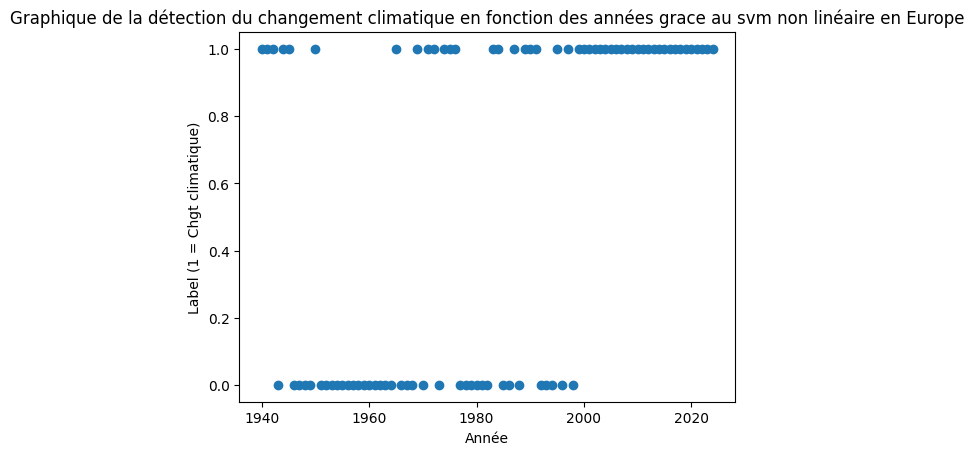

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, y_obs_EU, 'o')
plt.xlabel('Année')
plt.ylabel('Label (1 = Chgt climatique)')
plt.title('Graphique de la détection du changement climatique en fonction des années grace au svm non linéaire en Europe')
plt.show()

## Test bayésien

Calculer les Facteur de Bayes (voir également(Kass & Raftery 1995)) en utilisant les données que vous utilisé pour calculer une statistique. Une fois que le modèle de Gaussian Process est entraîné, vous obtenez une distribution postérieur pour chaque nouveau X=x* que vous voulez tester, i.e. une probabilité que Y=1 (changement climatique) et une autre pour Y=0 (pas de changement climatique), notons respectivement P(Y=1|X=x*) et P(Y=0|X=x*).


Nous pouvons alors calculer le facteur de bayes en prenant le ratio de ces deux probabilités, i.e. FB = P(Y=1|X=x*)/P(Y=0|X=x*). Si FB>1 cela signifie que le test penche en faveur du changement climatique. Vous pouvez utiliser ces valeurs de référence des facteurs de bayes proposées par Jeffreys.

Le SVM est entraîné sur les données d'entraînement

Le SVM génère des probabilités pour les données de test

Ces probabilités sont utilisées comme features pour entraîner le GPC

Le GPC fournit ensuite des probabilités qui sont utilisées pour calculer le facteur de Bayes

In [ ]:
def facteur_bayesien(data, labels, svm_model):
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_bayes_torch(data, labels)

    svm_proba = svm_model.predict_proba(X_test)
    svm_proba_feature = svm_proba[:, 1].reshape(-1, 1)

    kernel = 1.0 * RBF(length_scale=1.0)  # RBF Kernel pour GPC
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
    gpc.fit(svm_proba_feature, y_test)

    FB = gpc.predict_proba(svm_proba_feature)[:, 1] / gpc.predict_proba(svm_proba_feature)[:, 0]

    return FB, y_test, X_test, gpc

In [ ]:
def test_bayesien(data, labels, svm_model):
    FB, y_test, X_test, gpc = facteur_bayesien(data, labels, svm_model)

    predictions = (FB > 1).astype(int)

    bayes_scores = np.zeros_like(FB)

    bayes_scores[FB < 1] = 0                   # Preuve contre le changement climatique
    bayes_scores[(FB >= 1) & (FB < 3)] = 1     # Évidence faible
    bayes_scores[(FB >= 3) & (FB < 10)] = 2    # Preuve modérée
    bayes_scores[(FB >= 10) & (FB < 30)] = 3   # Preuve forte
    bayes_scores[(FB >= 30) & (FB < 100)] = 4  # Preuve très forte
    bayes_scores[FB >= 100] = 5                # Preuve décisive

    return bayes_scores, predictions, y_test, X_test, gpc

In [ ]:
def predict_observation(svm_model, gpc, X_obs):

    # Prédire avec SVM
    svm_probs = svm_model.predict_proba(X_obs)
    svm_probs_feature = svm_probs[:, 1].reshape(-1, 1)

    # Prédire avec GPC
    gpc_probs = gpc.predict_proba(svm_probs_feature)

    # Calculer le facteur de Bayes
    FB = gpc_probs[:, 1] / gpc_probs[:, 0]

    # Interpréter selon l'échelle de Jeffreys
    bayes_scores = np.zeros_like(FB)
    bayes_scores[FB < 1] = 0
    bayes_scores[(FB >= 1) & (FB < 3)] = 1
    bayes_scores[(FB >= 3) & (FB < 10)] = 2
    bayes_scores[(FB >= 10) & (FB < 30)] = 3
    bayes_scores[(FB >= 30) & (FB < 100)] = 4
    bayes_scores[FB >= 100] = 5

    return FB, bayes_scores

In [ ]:
bayes_scores, predictions, y_true, X_test, gpc = test_bayesien(data, labels, svm_model)

accuracy = accuracy_score(y_true, predictions)
print(f"Précision: {accuracy:.4f}")

for i, label in enumerate(["Preuve contre", "Évidence faible", "Preuve modérée",
                          "Preuve forte", "Preuve très forte", "Preuve décisive"]):
    count = np.sum(bayes_scores == i)
    percentage = (count / len(bayes_scores)) * 100
    print(f"{label}: {count} cas ({percentage:.2f}%)")

FB_obs, score_obs = predict_observation(svm_model, gpc, X_obs)

Précision: 0.8973
Preuve contre: 660 cas (48.42%)
Évidence faible: 100 cas (7.34%)
Preuve modérée: 92 cas (6.75%)
Preuve forte: 62 cas (4.55%)
Preuve très forte: 449 cas (32.94%)
Preuve décisive: 0 cas (0.00%)


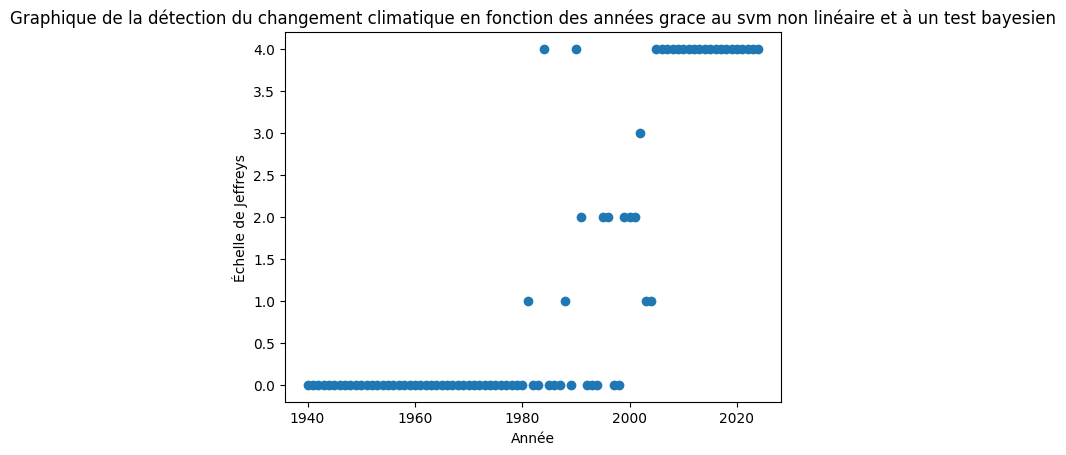

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, score_obs, 'o')
plt.xlabel('Année')
plt.ylabel('Échelle de Jeffreys')
plt.title('Graphique de la détection du changement climatique en fonction des années grace au svm non linéaire et à un test bayesien')
plt.show()

Pour une région

In [ ]:
bayes_scores, predictions, y_true, X_test, gpc = test_bayesien(data_AM, labels_AM, svm_model_AM)

accuracy = accuracy_score(y_true, predictions)
print(f"Précision: {accuracy:.4f}")

for i, label in enumerate(["Preuve contre", "Évidence faible", "Preuve modérée",
                          "Preuve forte", "Preuve très forte", "Preuve décisive"]):
    count = np.sum(bayes_scores == i)
    percentage = (count / len(bayes_scores)) * 100
    print(f"{label}: {count} cas ({percentage:.2f}%)")

FB_obs, score_obs = predict_observation(svm_model_AM, gpc, X_obs_AM)

Précision: 0.8020
Preuve contre: 755 cas (54.36%)
Évidence faible: 163 cas (11.74%)
Preuve modérée: 186 cas (13.39%)
Preuve forte: 185 cas (13.32%)
Preuve très forte: 100 cas (7.20%)
Preuve décisive: 0 cas (0.00%)


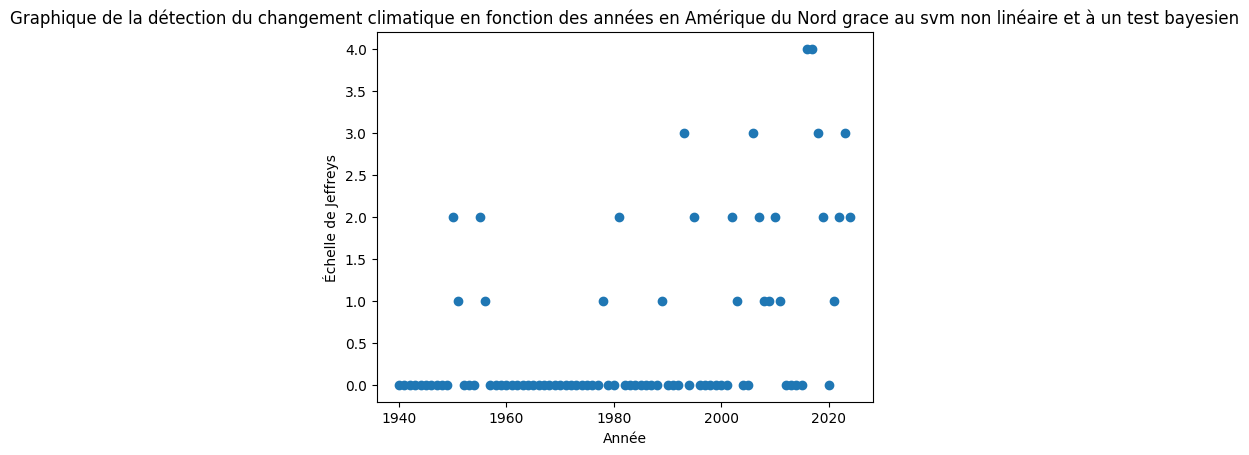

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, score_obs, 'o')
plt.xlabel('Année')
plt.ylabel('Échelle de Jeffreys')
plt.title('Graphique de la détection du changement climatique en fonction des années en Amérique du Nord grace au svm non linéaire et à un test bayesien')
plt.show()

In [ ]:
bayes_scores, predictions, y_true, X_test, gpc = test_bayesien(data_EU, labels_EU, svm_model_EU)

accuracy = accuracy_score(y_true, predictions)
print(f"Précision: {accuracy:.4f}")

for i, label in enumerate(["Preuve contre", "Évidence faible", "Preuve modérée",
                          "Preuve forte", "Preuve très forte", "Preuve décisive"]):
    count = np.sum(bayes_scores == i)
    percentage = (count / len(bayes_scores)) * 100
    print(f"{label}: {count} cas ({percentage:.2f}%)")

FB_obs, score_obs = predict_observation(svm_model_EU, gpc, X_obs_EU)

Précision: 0.7111
Preuve contre: 601 cas (41.74%)
Évidence faible: 242 cas (16.81%)
Preuve modérée: 597 cas (41.46%)
Preuve forte: 0 cas (0.00%)
Preuve très forte: 0 cas (0.00%)
Preuve décisive: 0 cas (0.00%)


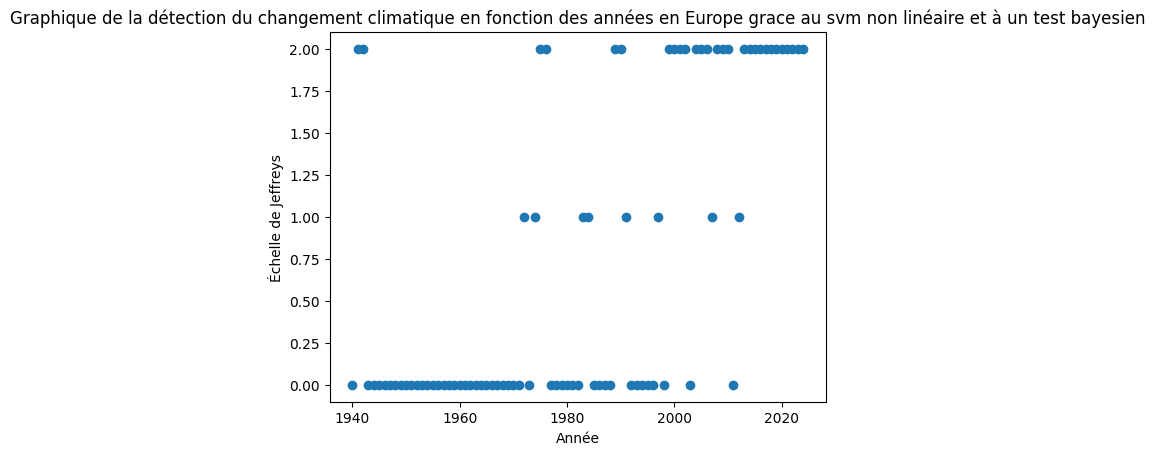

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, score_obs, 'o')
plt.xlabel('Année')
plt.ylabel('Échelle de Jeffreys')
plt.title('Graphique de la détection du changement climatique en fonction des années en Europe grace au svm non linéaire et à un test bayesien')
plt.show()

## Conclusion

Résultat dans la ligné des précédents.

On peut noter qu'avec le split bayésien, on obtient une puissance de test supérieure à celle obtenue avec le plit random même si on a du rajouter de l'aléa pour parvenir à faire ce split.

On pourrait tester:
- faire varier les paramètre du SVM
- essasyer un kernel poly pour le GP
- retirer les données de 1940 à 1960
- une autre méthode pour résoudre le problème des quartiles
-

Etape suivante, faire un test statistique bayésien et non fréquentiste